In [59]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import time
import matplotlib.pyplot as plt

In [10]:
ratings=pd.read_table('ml-1m\\ratings.dat',sep='::',header=None,engine='python',names=['UserID','MovieID','Rating','Timestamp'])
ratings.drop(columns=['Timestamp'],inplace=True)

In [8]:
def global_rating(train):
    return(np.mean(train['Rating']))
def user_rating(train):   
    return(train.groupby('UserID',as_index=False)['Rating'].mean())
def item_rating(train):
    return(train.groupby('MovieID',as_index=False)['Rating'].mean())
def item_user(train):
    user=user_rating(train)
    movie=item_rating(train)
    X=pd.merge(pd.merge(train,pd.DataFrame(user),on=['UserID']),pd.DataFrame(movie),on=['MovieID'],sort=False)
    y=X['Rating_x'] 
    X=X[['Rating_y','Rating']]
    #reg = LinearRegression().fit(X, y)
    return(y,X) 


In [7]:
def global_pred(train,test):
    g=global_rating(train)
    return(g,g,train['Rating'],test['Rating'])
def user_rating_pred(train,test):
    g=global_rating(train)
    user=user_rating(train)
    res=pd.merge(test,pd.DataFrame(user),on=['UserID'],how='left',sort=False)
    res.loc[res['Rating_y'].isnull(),'Rating_y']=g
    res_2=pd.merge(train,pd.DataFrame(user),on=['UserID'],sort=False)
    train_label=res_2['Rating_x']
    train_pred=res_2['Rating_y']
    test_pred=res['Rating_y']
    test_label=res['Rating_x']
    return(train_pred,test_pred,train_label,test_label)
def movie_rating_pred(train,test):
    g=global_rating(train)
    movie=item_rating(train)
    res=pd.merge(test,pd.DataFrame(movie),on=['MovieID'],how='left',sort=False)
    res.loc[res['Rating_y'].isnull(),'Rating_y']=g
    res_2=pd.merge(train,pd.DataFrame(movie),on=['MovieID'],sort=False)
    train_label=res_2['Rating_x']
    train_pred=res_2['Rating_y']
    test_pred=res['Rating_y']
    test_label=res['Rating_x']
    return(train_pred,test_pred,train_label,test_label)
def item_user_pred(train,test):
    g=global_rating(train)
    y_train,X_train=item_user(train)
    reg = LinearRegression().fit(X_train, y_train)
    user=user_rating(train)
    movie=item_rating(train)
    X=pd.merge(pd.merge(test,pd.DataFrame(user),on=['UserID'],how='left'),pd.DataFrame(movie),on=['MovieID'],how='left',sort=False)
    test_label=X['Rating_x']  
    X=X[['Rating_y','Rating']]
    X.fillna(g, inplace=True)
    pred_test=reg.predict(X)
    X_train=pd.merge(pd.merge(train,pd.DataFrame(user),on=['UserID']),pd.DataFrame(movie),on=['MovieID'],sort=False)
    train_label=X_train['Rating_x']  
    X_train=X_train[['Rating_y','Rating']]
    pred_train=reg.predict(X_train)
    pred_test[pred_test>5]=5
    pred_test[pred_test<1]=1
    pred_train[pred_train>5]=5
    pred_train[pred_train<1]=1
    return(pred_train,pred_test,train_label,test_label)
def item_user_pred_2(train,test):
    g=global_rating(train)
    y_train,X_train=item_user(train)
    reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    user=user_rating(train)
    movie=item_rating(train)
    X=pd.merge(pd.merge(test,pd.DataFrame(user),on=['UserID'],how='left'),pd.DataFrame(movie),on=['MovieID'],how='left',sort=False)
    test_label=X['Rating_x']  
    X=X[['Rating_y','Rating']]
    X.fillna(g, inplace=True)
    pred_test=reg.predict(X)
    X_train=pd.merge(pd.merge(train,pd.DataFrame(user),on=['UserID']),pd.DataFrame(movie),on=['MovieID'],sort=False)
    train_label=X_train['Rating_x']  
    X_train=X_train[['Rating_y','Rating']]
    pred_train=reg.predict(X_train)
    pred_test[pred_test>5]=5
    pred_test[pred_test<1]=1
    pred_train[pred_train>5]=5
    pred_train[pred_train<1]=1
    return(pred_train,pred_test,train_label,test_label)

In [5]:
def error(pred,y):
    rmse=(np.nanmean((pred-y)**2))**0.5
    mae=np.nanmean(abs(pred-y))
    return(rmse,mae)

In [6]:
def cross(data,func):
    np.random.seed(2898144)
    ran=list(np.random.choice(range(len(ratings)),len(ratings),replace=False))
    test_error=np.zeros((5,2))
    train_error=np.zeros((5,2))
    for i in range(5):
        test=data.iloc[ran[i::5]]
        train=data.drop(ran[i::5])
        train_pred,test_pred,train_label,test_label=func(train,test)     
        test_error[i,:]=error(test_pred,test_label)
        train_error[i,:]=error(train_pred,train_label)
    return(np.mean(train_error,0),np.mean(test_error,0))

In [ ]:
cross(ratings,global_pred)

In [ ]:
cross(ratings,user_rating_pred)

In [ ]:
cross(ratings,movie_rating_pred)

In [ ]:
cross(ratings,item_user_pred)

In [ ]:
cross(ratings,item_user_pred_2)

In [13]:
t0=time.time()
for i in range(10):
    cross(ratings,global_pred)
t1=time.time()
t1-t0

1.1808173656463623

In [14]:
t0=time.time()
for i in range(10):
    cross(ratings,user_rating_pred)
t1=time.time()
t1-t0

2.054514169692993

In [15]:
t0=time.time()
for i in range(10):
    cross(ratings,movie_rating_pred)
t1=time.time()
t1-t0

2.23736572265625

In [23]:
t0=time.time()
for i in range(10):
    cross(ratings,item_user_pred)
t1=time.time()
t1-t0

63.780582427978516

In [24]:
t0=time.time()
for i in range(10):
    cross(ratings,item_user_pred_2)
t1=time.time()
t1-t0

62.23153018951416

In [567]:
# slower method, not used
for s in range(4):
        vv=np.array(V[s,:])
        mm=np.zeros(np.shape(M))
        mm[:,:]=vv
        mm[np.isnan(M)]=np.nan
        below=np.nansum(np.square(mm),1)
        my_sum=np.matmul(U,V)-np.matmul(U[:,s].reshape(-1,1),V[s,:].reshape(1,-1))
        above=np.nansum(V[s,:]*(M-my_sum),1)
        U[:,s]=above/below
U

<ipython-input-567-7c9f3c924fb1>:10: RuntimeWarning: invalid value encountered in true_divide
  U[:,s]=above/below


array([[-0.98445122, -0.11659496, -0.57109488,  0.18988856],
       [-0.68562196, -0.27802573, -0.3745213 , -0.77575625],
       [-0.49822704, -0.39654629,  0.14288945, -0.8460524 ],
       ...,
       [-1.7242489 , -0.07956161, -0.45670085,  0.8692773 ],
       [ 2.16770524,  0.80070366, -3.67824517,  0.84327669],
       [-0.51362769,  0.35982786, -0.72508214, -0.13439939]])

In [569]:

for r in R:
        for s in D: 
            mm=np.array(M[r,:])
            if np.nansum(mm)==0:
                continue
            vv=np.array(V[s,:])
            #vv=np.nan((s,0))
            vv[np.isnan(mm)]=np.nan
            below=np.nansum(np.square(vv))
            my_sum=np.matmul(U[r,:],V[:])-(U[r,s]*V[s,:])
            #my_sum=np.matmul(U,V)-np.matmul(U[:,s].reshape(-1,1),V[s,:].reshape(1,-1))
            above=np.nansum(V[s,:]*(mm-my_sum))
            #above=np.nansum(V[s,:]*(mm-my_sum),1)
            U[r,s]=0.5*(above)/below
U

array([[-0.43834476, -0.02977602, -0.23300422,  0.05446093],
       [-0.32579279, -0.10780408, -0.15786782, -0.38777834],
       [-0.23264629, -0.18474583,  0.06283148, -0.42425281],
       ...,
       [-0.64293321,  0.00354489, -0.21201845,  0.27032768],
       [ 0.42535153,  0.13683307, -1.04319859,  0.34388617],
       [-0.24953458,  0.17466448, -0.35163485, -0.10813375]])

In [28]:
def Matrix_U(R,D,U,V,M):
    for r in R:
        
        for s in D:
            mm=np.array(M[r,:])
            if np.nansum(mm)==0:
                continue 
            vv=np.array(V[s,:])
            vv[np.isnan(mm)]=np.nan
            below=np.nansum(np.square(vv))
            my_sum=np.matmul(U[r,:],V[:])-(U[r,s]*V[s,:])
            above=np.nansum(V[s,:]*(mm-my_sum))
            U[r,s]=0.7*U[r,s]+0.3*(above)/below

    return(U)

def Matrix_V(S,D,U,V,M):
    for s in S:

        for r in D:
            mm=np.array(M[:,s])
            if np.nansum(mm)==0:
                continue
            uu=np.array(U[:,r]) 
            uu[np.isnan(mm)]=np.nan
            below=np.nansum(np.square(uu))
            my_sum=np.matmul(U[:],V[:,s])-(V[r,s]*U[:,r])
            above=np.nansum(U[:,r]*(mm-my_sum))
            V[r,s]=0.7*V[r,s]+0.3*(above)/below

    return(V)



In [29]:
t0=time.time()
test_error=np.zeros((50,5,2))
train_error=np.zeros((50,5,2))
np.random.seed(2898144)
ran=list(np.random.choice(range(len(ratings)),len(ratings),replace=False))
for i in range(5):
    test=ratings.iloc[ran[i::5]]
    train=ratings.drop(ran[i::5])
    train=pd.merge(ratings.drop(columns=['Rating']),train,how='left',sort=False)
    mean_user=user_rating(train)
    normal=pd.merge(train,mean_user,on=('UserID'),suffixes=('_a','_b'),how='left',sort=False)
    normal['Rating']=normal['Rating_a']-normal['Rating_b']
    mean_movie=item_rating(normal)
    normal=pd.merge(normal,mean_movie,on=('MovieID'),how='left',sort=False)
    normal['Rating']=normal['Rating_x']-normal['Rating_y'] 
    M=pd.merge(ratings.drop(columns=['Rating']),train,'left')
    M=normal[['UserID','MovieID','Rating']]
    M=M.pivot(index='MovieID', columns='UserID', values='Rating')
    M=np.array(M)
    a=np.nanmean(M)
    d=3
    n=np.shape(M)[0]
    m=np.shape(M)[1]
    var=np.nanvar(M)
    U=np.random.normal(0,np.sqrt(var),size=(n,d))
    V=np.random.normal(0,np.sqrt(var),size=(d,m))
    y=pd.merge(ratings.drop(columns=['Rating']),test,'left',sort=False)
    y=y.pivot(index='MovieID', columns='UserID', values='Rating')
    y=np.array(y)
    for ii in range(50):       
        S=list(np.random.choice(range(m),m,False))
        D=list(np.random.choice(range(d),d,False))
        R=list(np.random.choice(range(n),n,False))
        U=Matrix_U(R,D,U,V,M)
        V=Matrix_V(S,D,U,V,M)
        pred=np.dot(U,V)
        unique_movie=pd.DataFrame(np.unique(ratings['MovieID']),columns=['MovieID'])
        mean_movie=pd.merge(unique_movie,mean_movie,how='left',sort=False)
        mean_movie.fillna(np.nanmean(mean_movie),inplace=True)
        unique_user=pd.DataFrame(np.unique(ratings['UserID']),columns=['UserID'])
        mean_user=pd.merge(unique_user,mean_user,how='left',sort=False)
        mean_user.fillna(np.nanmean(mean_user),inplace=True)
        pred=pred+np.array(mean_movie['Rating']).reshape(-1,1)
        pred=pred+np.array(mean_user['Rating'])   
        pred[pred>5]=5
        pred[pred<1]=1
        test_error[ii,i,:]=error(pred,y)
        T=train.pivot(index='MovieID', columns='UserID', values='Rating')
        train_error[ii,i,:]=error(pred,T)
print(np.mean(test_error,0),np.mean(train_error,0))
t1=time.time()
t0-t1

[[0.91720399 0.71886768]
 [0.90946419 0.71107413]
 [0.91459159 0.71400066]
 [0.91408065 0.71509056]
 [0.91594279 0.71610086]] [[0.86940035 0.68332024]
 [0.86419534 0.67812408]
 [0.86681447 0.68023626]
 [0.86598805 0.67936392]
 [0.86857233 0.68178082]]


-2113.431747198105

In [83]:
t0=time.time()
test_error=np.zeros((5,2))
train_error=np.zeros((5,2))
np.random.seed(2898144)
ran=list(np.random.choice(range(len(ratings)),len(ratings),replace=False))
for i in range(5):
    test=ratings.iloc[ran[i::5]]
    train=ratings.drop(ran[i::5])
    train=pd.merge(ratings.drop(columns=['Rating']),train,how='left',sort=False)
    mean_user=user_rating(train)
    normal=pd.merge(train,mean_user,on=('UserID'),suffixes=('_a','_b'),how='left',sort=False)
    normal['Rating']=normal['Rating_a']-normal['Rating_b']
    mean_movie=item_rating(normal)
    normal=pd.merge(normal,mean_movie,on=('MovieID'),how='left',sort=False)
    normal['Rating']=normal['Rating_x']-normal['Rating_y'] 
    M=pd.merge(ratings.drop(columns=['Rating']),train,'left')
    M=normal[['UserID','MovieID','Rating']]
    M=M.pivot(index='MovieID', columns='UserID', values='Rating')
    M=np.array(M)
    a=np.nanmean(M)
    d=3
    n=np.shape(M)[0]
    m=np.shape(M)[1]
    var=np.nanvar(M)
    U=np.random.normal(0,np.sqrt(var),size=(n,d))
    V=np.random.normal(0,np.sqrt(var),size=(d,m))
    y=pd.merge(ratings.drop(columns=['Rating']),test,'left',sort=False)
    y=y.pivot(index='MovieID', columns='UserID', values='Rating')
    y=np.array(y)
    for ii in range(50):       
        S=list(np.random.choice(range(m),m,False))
        D=list(np.random.choice(range(d),d,False))
        R=list(np.random.choice(range(n),n,False))
        U=Matrix_U(R,D,U,V,M)
        V=Matrix_V(S,D,U,V,M)
    pred=np.dot(U,V)
    unique_movie=pd.DataFrame(np.unique(ratings['MovieID']),columns=['MovieID'])
    mean_movie=pd.merge(unique_movie,mean_movie,how='left',sort=False)
    mean_movie.fillna(np.nanmean(mean_movie),inplace=True)
    unique_user=pd.DataFrame(np.unique(ratings['UserID']),columns=['UserID'])
    mean_user=pd.merge(unique_user,mean_user,how='left',sort=False)
    mean_user.fillna(np.nanmean(mean_user),inplace=True)
    pred=pred+np.array(mean_movie['Rating']).reshape(-1,1)
    pred=pred+np.array(mean_user['Rating'])   
    pred[pred>5]=5
    pred[pred<1]=1
    test_error[i,:]=error(pred,y)
    T=train.pivot(index='MovieID', columns='UserID', values='Rating')
    train_error[i,:]=error(pred,T)
print(np.mean(test_error,0),np.mean(train_error,0))
t1=time.time()
t0-t1

[0.89066155 0.69594591] [0.8436505  0.66195215]


-1441.8264677524567

In [33]:
test_results=np.mean(test_error,1)
train_results=np.mean(train_error,1)

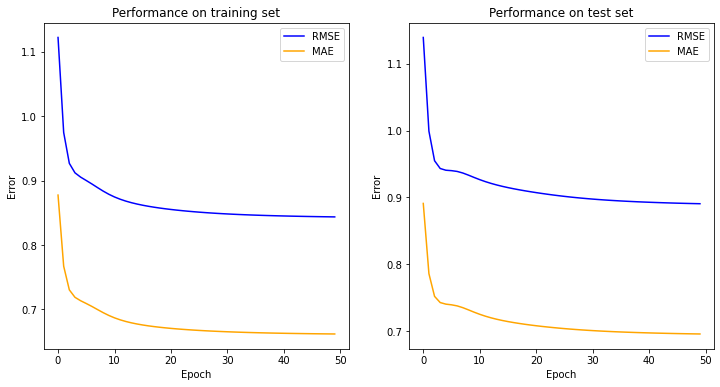

In [81]:
X=list(range(len(train_results)))
fig = plt.figure(figsize=(12, 6))
train_ax1 = fig.add_subplot(121)
train_ax1.plot(X, train_results[:,0], color='blue', label='RMSE')
train_ax1.plot(X, train_results[:,1], color='orange', label='MAE')
test_ax2 = fig.add_subplot(122)
test_ax2.plot(X, test_results[:,0], color='blue', label='RMSE')
test_ax2.plot(X, test_results[:,1], color='orange', label='MAE')
train_ax1.set_xlabel('Epoch')
train_ax1.set_ylabel('Error')
test_ax2.set_ylabel('Error')
test_ax2.set_xlabel('Epoch')
train_ax1.set_title('Performance on training set')
test_ax2.set_title('Performance on test set') 
train_ax1.legend()
test_ax2.legend() 
plt.show()